In [94]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import scipy.stats as stats

from pymc3.distributions.timeseries import EulerMaruyama


# Estimating the parameters of a stock evolving according to geometric Brownian motion

Here we want to estimate the parameters of a stock evolving according to geometric Brownian motion. In this case the stock price evolves according to
$$
dS_{t} = \mu S_{t} dt + \sigma S_{t} dW_{t}
$$

In [118]:
# Define some useful functions

def stockprice(S0, t, mu, sigma, n):

    """
    This function will return the stock price at time t given the initial stock price S0, the drift mu, the volatility sigma, and the number 
    n is number of sampes
    """

    # Calculate the stock price at time t
    St = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * np.sqrt(t) * np.random.normal(0, 1, n))

    return St

def stockprice_evolution(S0, t, dt, mu, sigma, n):

    "Simulate stock price according to geometric brownian motion"

    St = np.zeros((n, len(t)))
    St[:, 0] = S0

    for i in range(1, len(t)):
        St[:, i] = St[:, i-1] * (1 + mu * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1, n))

    return St
    
def stock_pdf(s, S0, t, mu, sigma):

    """
    This function computes the probability density function of the stock price at time t given the initial stock price S0, 
    the drift mu, the volatility sigma, and the stock price s
    """

    # Calculate the stock price at time t
    pdf = (1 / (s * sigma * np.sqrt(2 * np.pi * t))) * np.exp(-((np.log(s / S0) - (mu - 0.5 * sigma**2) * t)**2) / (2 * sigma**2 * t))

    return pdf


In [158]:
# Define the parameters
mu_t = 0.06
sigma_t = 0.2
S0 = 100
n = 1

# Define the time period
dt = 0.01
t = np.arange(0, 10, dt)

# Calculate the stock price at time t
St = stockprice_evolution(S0, t, dt, mu_t, sigma_t, n)
true_pdf = stock_pdf(s, S0, t[-1], mu_t, sigma_t)

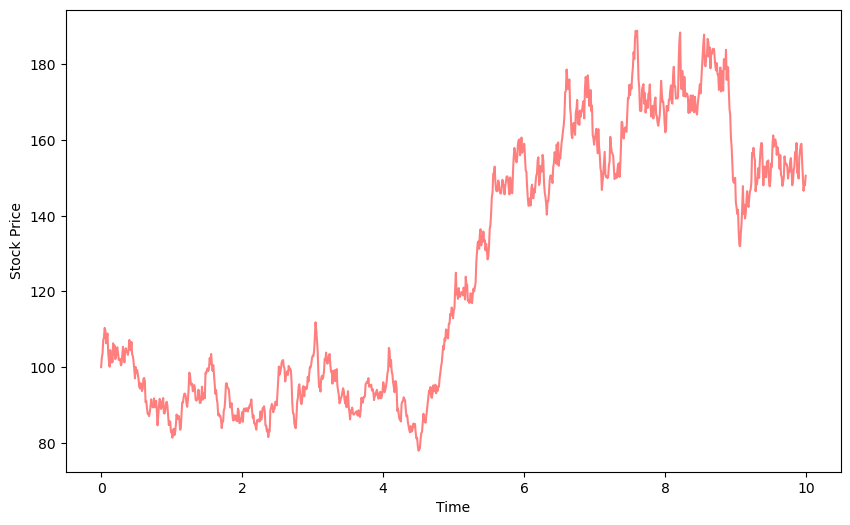

In [149]:
fig = plt.figure(figsize=(10, 6))
plt.plot(t, St[:1000, :].T, color='r', alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

# Using pymc3 to fit a model to data

Here we want to use pymc3 to estimate the parameters of the geometric brownian motion describing the evolution of a stock price

In [150]:
# We begin by defining a linear sde model returning the drift and diffusion coefficients
def lin_sde(x, mu, sigma):
    return mu * x, sigma * x

with pm.Model() as model:
    # Define the parameters
    mu = pm.Normal("mu", mu=0, sigma=0.1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # Define the stock price evolution
    stock = EulerMaruyama("stock", dt, lin_sde, (mu, sigma), shape=len(t), testval=St[0])

    # Define the likelihood
    likelihood = pm.Normal("likelihood", mu=stock, sigma=0.1, observed=St)

    # Inference button (TM)!
    trace = pm.sample(2000, tune=1000, cores=1)


/Users/michael/miniconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.


/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_44646/2819122774.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mu_vals, ax=axes[0])
/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_44646/2819122774.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sigma_vals, ax=axes

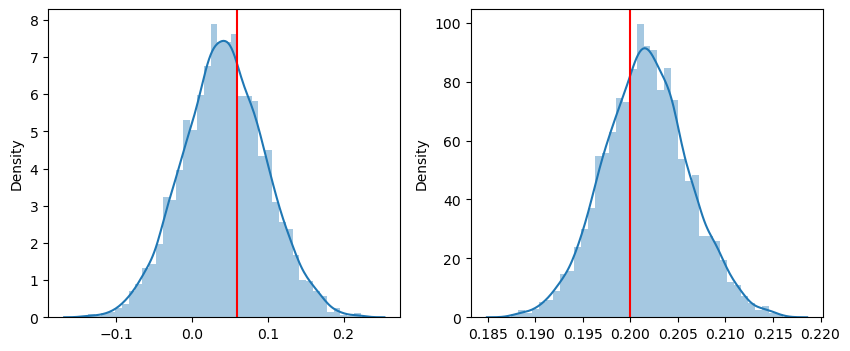

In [151]:
mu_vals = trace.get_values("mu")
sigma_vals = trace.get_values("sigma")

# Make histograms of mu and sigma using seaborn with kernel density estimation
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.distplot(mu_vals, ax=axes[0])
sns.distplot(sigma_vals, ax=axes[1])

# add verticle lines where means are
axes[0].axvline(mu_t, color='r')
axes[1].axvline(sigma_t, color='r')

plt.show()

In [152]:
# Compute some useful statistics from the trace
mu_mean = np.mean(mu_vals)
mu_std = np.std(mu_vals)
sigma_mean = np.mean(sigma_vals)
sigma_std = np.std(sigma_vals)

# Compute fractional error in mu and sigma
mu_err = np.abs(mu_mean - mu_t) / mu_t
sigma_err = np.abs(sigma_mean - sigma_t) / sigma_t

print(f"mu: {mu_mean:.3f} +/- {mu_std:.3f} (error: {mu_err:.3f})")
print(f"sigma: {sigma_mean:.3f} +/- {sigma_std:.3f} (error: {sigma_err:.3f})")


mu: 0.043 +/- 0.054 (error: 0.289)
sigma: 0.202 +/- 0.004 (error: 0.008)


In [153]:
# get probabilities of mu histogram
dmu = 0.01
dsigma = 0.01
mus = np.arange(mu_mean - 4 * mu_std, mu_mean + 4 * mu_std, dmu)
sigmas = np.arange(sigma_mean - 4 * sigma_std, sigma_mean + 4 * sigma_std, dsigma)

# get normal distribution for mu
mu_pdf = stats.norm.pdf(mus, mu_mean, mu_std)
sigma_pdf = stats.norm.pdf(sigmas, sigma_mean, sigma_std)



# Making use of the marginal distribution

Now we want to compute the probability distribution over the future stock values given our distributions over $\mu$ and $\sigma$. This distribution is given by 
$$
P(s) = \int \int P(s|\mu,\sigma) P(\mu)P(\sigma) d\mu d\sigma
$$

In [160]:
ds = 0.1
s = np.arange(0.01, t[-1]*S0, ds)


pdfs = np.zeros((len(mus), len(sigmas), len(s)))
for i, mu in enumerate(mus):
    for j, sigma in enumerate(sigmas):
        pdfs[i, j, :] = stock_pdf(s, S0, t[-1], mu, sigma) * mu_pdf[i] * sigma_pdf[j]

# sum over mu and sigma
estimated_pdf = np.sum(pdfs, axis=(0, 1))*dmu*dsigma

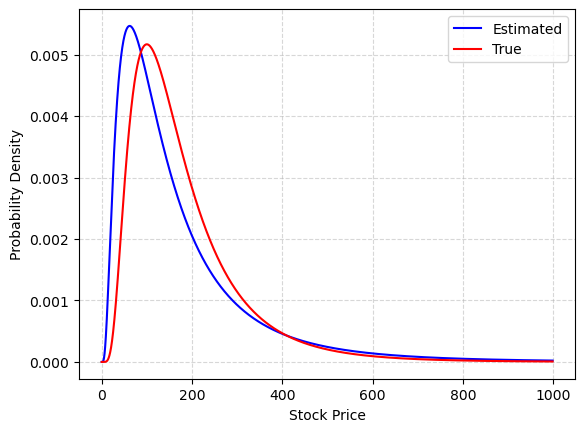

In [161]:
# Plot the estimated stock price distribution
plt.plot(s, estimated_pdf, color='b', label='Estimated')
plt.plot(s, true_pdf, color='r', label='True')
plt.xlabel("Stock Price")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [162]:
np.sum(estimated_pdf*s)*ds

170.05767179729258

In [163]:
np.sum(true_pdf*s)*ds

180.51166109170808